In [4]:
# !pip install -U sagemaker #installing latest sagemaker

In [2]:
!pip install --upgrade pip # upgrading pip to install sagemaker and others if not installed by default on pytorch environment

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [6]:
import sagemaker #  skd for model training and deployment
import boto3  # sdk for AWS resources management 

s3 = boto3.client('s3')
bucket_url = 's3://banana-vision-oregon/data'   # bucket in use

In [7]:
# setting data channels to be used on the training
data_channels = {
    "train": f'{bucket_url}/train/',
    "valid": f'{bucket_url}/valid/',
    "test": f'{bucket_url}/test/'
}

In [14]:
# checking the data channels path and if they are correctly set
import os

for channel, path in data_channels.items():
    os.environ[f'SM_CHANNEL_{channel.upper()}'] = path
    
    
for channel in data_channels:
    channel_key = f"SM_CHANNEL_{channel.upper()}"
    if channel_key not in os.environ:
        print(f"Environment variable {channel_key} not set")
    else:
        print(f"Using {channel_key}: {os.environ[channel_key]}")

Using SM_CHANNEL_TRAIN: s3://banana-vision-oregon/data/train/
Using SM_CHANNEL_VALID: s3://banana-vision-oregon/data/valid/
Using SM_CHANNEL_TEST: s3://banana-vision-oregon/data/test/


In [20]:
# Import the PyTorch class from the SageMaker PyTorch module and a function to get the execution role
from sagemaker.pytorch import PyTorch
role = sagemaker.get_execution_role()  # Obtain the AWS execution role for the SageMaker session

# Create a PyTorch estimator for training
pytorch_estimator = PyTorch(
    entry_point='training_final+gaussian_noise_on_preprocessing.py',  # Path to the training script
    role=role,  # The execution role obtained above
    framework_version='2.1.0',  # Version of the PyTorch framework to use
    py_version='py310',  # Python version to be used
    instance_count=1,  # Number of instances to use for training
    instance_type='ml.m5.4xlarge',  # Type of EC2 instance to use for training
    hyperparameters={'epochs': 10, 'batch-size': 32, 'num-classes': 3}  # Hyperparameters for the training job
)

# Start the training job with the provided data channels
pytorch_estimator.fit(data_channels)  # 'data_channels' should be a predefined variable with data paths


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating training-job with name: pytorch-training-2023-12-06-10-03-14-172


2023-12-06 10:03:14 Starting - Starting the training job...
2023-12-06 10:03:29 Starting - Preparing the instances for training......
2023-12-06 10:04:41 Downloading - Downloading input data.........
2023-12-06 10:06:02 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-12-06 10:06:03,116 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-12-06 10:06:03,117 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-06 10:06:03,118 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-12-06 10:06:03,127 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-12-06 10:06:03,129 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-12-06 10:06:04,560 sagemaker-training-toolkit I

### Deployment

In [5]:
# extracting the training image name from previously trained and saved model
import sagemaker

sagemaker_session = sagemaker.Session()
training_job_name = 'pytorch-training-2023-12-01-23-23-54-923'  # training job name

# Get the training job description
training_job_description = sagemaker_session.sagemaker_client.describe_training_job(
    TrainingJobName=training_job_name
)

# Extract the training image (Docker container URI)
training_image = training_job_description['AlgorithmSpecification']['TrainingImage']
print("Training Image:", training_image)


Training Image: 763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-training:2.1.0-cpu-py310


In [22]:
# Import the SageMaker Python SDK
import sagemaker
# Import specific functions from the SageMaker Python SDK
from sagemaker import get_execution_role
from sagemaker.model import Model

# Obtain the AWS execution role for the SageMaker session
role = get_execution_role()  
# Create a SageMaker session object, which manages interactions with the SageMaker service
sagemaker_session = sagemaker.Session()

# Create a SageMaker Model object
model = Model(
    model_data='s3://sagemaker-us-west-2-187079857366/pytorch-training-2023-12-01-23-23-54-923/output/model.tar.gz',  # S3 path to the trained model artifacts
    image_uri='763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-training:2.1.0-cpu-py310',  # URI for the Docker container image to be used for deployment
    role=role,  # The AWS execution role obtained earlier
    sagemaker_session=sagemaker_session  # The SageMaker session object created earlier
)

In [28]:
# Import the PyTorchModel class from the sagemaker.pytorch module
from sagemaker.pytorch import PyTorchModel

# Create an instance of the PyTorchModel class
pytorch_model = PyTorchModel(
    model_data='s3://sagemaker-us-west-2-187079857366/pytorch-training-2023-12-01-23-23-54-923/output/model.tar.gz',  # S3 path to the trained PyTorch model artifacts
    role=role,  # AWS IAM role with permissions for SageMaker operations
    entry_point='inference.py',  # Script file for model inference (entry point for predictions)
    framework_version='2.1.0',  # Version of the PyTorch framework to use
    py_version='py310'  # Python version to be used
)

In [29]:
# Deploy the PyTorch model created earlier as an endpoint on AWS SageMaker
predictor = pytorch_model.deploy(
    initial_instance_count=1,  # Specify the number of instances for the endpoint (1 in this case)
    instance_type='ml.m5.xlarge'  # Define the type of EC2 instance to use for the endpoint
)

----!

In [35]:
from PIL import Image
import io

# Load your image
image_path = './unseen/Image_3533.jpg' 
with open(image_path, 'rb') as f:
    payload = f.read()


In [36]:
# Importing required libraries
import boto3  # AWS SDK for Python, allows Python code to interact with AWS services
import json  # Module for working with JSON data

# Initializing a SageMaker runtime client using boto3
client = boto3.client('sagemaker-runtime')  # This client provides a method to invoke the endpoint

# Define the SageMaker endpoint name to which the request will be sent
endpoint_name = 'pytorch-inference-2023-12-02-22-34-19-675'  # Name of the SageMaker endpoint for inference

# Making an inference request to the specified endpoint
response = client.invoke_endpoint(
    EndpointName=endpoint_name,  # Specifying the endpoint name
    Body=payload,  # Payload for the inference request, should be defined earlier in your code
    ContentType='application/x-image',  # The MIME type of the input data (in this case, an image)
    Accept='application/json'  # The desired MIME type of the inference in the response
)

# Parsing the response from the SageMaker endpoint
result = json.loads(response['Body'].read().decode())  # Decoding and loading the response to extract the result
print(result)  # Printing the result of the inference

{'predicted_class': 'FUSARIUM WILT', 'probabilities': {'BLACK SIGATOKA': 0.0989437848329544, 'FUSARIUM WILT': 0.9008161425590515, 'HEALTHY': 0.0002401060628471896}}


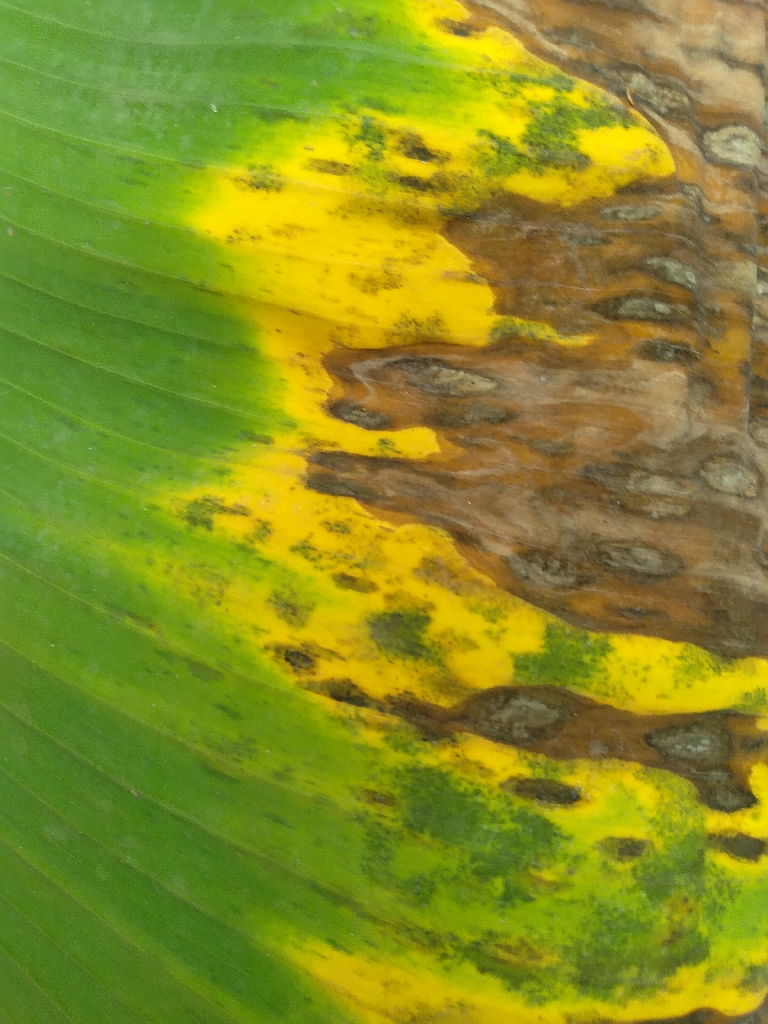

{'predicted_class': 'BLACK SIGATOKA', 'probabilities': {'BLACK SIGATOKA': 0.9998704195022583, 'FUSARIUM WILT': 0.00012935187260154635, 'HEALTHY': 2.096385571803694e-07}}


In [6]:
import boto3
import json
from IPython.display import Image, display

image_path = './unseen/Image_2796.jpg'

# Displaying the chosen image
display(Image(filename=image_path, width=500, height=500))

# Initializing a SageMaker runtime client
client = boto3.client('sagemaker-runtime')

# SageMaker endpoint name
endpoint_name = 'pytorch-inference-2023-12-02-22-34-19-675'


with open(image_path, 'rb') as f:
    payload = f.read()

# Inference request
response = client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=payload,
    ContentType='application/x-image',
    Accept='application/json'
)

# Parsing the response
result = json.loads(response['Body'].read().decode())
print(result)


In [2]:
import boto3
import json
import os

# Initializing a SageMaker runtime client
client = boto3.client('sagemaker-runtime')

# SageMaker endpoint name
endpoint_name = 'pytorch-inference-2023-12-02-22-34-19-675'

# Directory containing images
image_folder = './inference-test'

# Store results
results = []

# Loop through each image in the folder
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    
    # Read image as binary
    with open(image_path, 'rb') as file:
        payload = file.read()

    # Inference request
    response = client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=payload,
        ContentType='application/x-image',
        Accept='application/json'
    )

    # Parsing the response
    result = json.loads(response['Body'].read().decode())

    # Append result with image name
    results.append({
        'Image Name': image_name,
        'Prediction Result': result.get('predicted_class', 'N/A'),
        'Prediction Probability': f"{result.get('probability', 0) * 100}%"
    })

# Print final results
for res in results:
    print(f"Image: {res['Image Name']}, Prediction: {res['Prediction Result']}, Probability: {res['Prediction Probability']}")



Image: Image_2814.jpg, Prediction: FUSARIUM WILT, Probability: 0%
Image: Image_3066.jpg, Prediction: FUSARIUM WILT, Probability: 0%
Image: Image_3561.jpg, Prediction: FUSARIUM WILT, Probability: 0%
Image: Image_2832.jpg, Prediction: BLACK SIGATOKA, Probability: 0%
Image: Image_3048.jpg, Prediction: HEALTHY, Probability: 0%
Image: Image_2823.jpg, Prediction: BLACK SIGATOKA, Probability: 0%
Image: Image_3552.jpg, Prediction: FUSARIUM WILT, Probability: 0%
Image: Image_3057.jpg, Prediction: HEALTHY, Probability: 0%
Image: Image_3534.jpg, Prediction: FUSARIUM WILT, Probability: 0%
Image: Image_2818.jpg, Prediction: BLACK SIGATOKA, Probability: 0%
Image: Image_3547.jpg, Prediction: FUSARIUM WILT, Probability: 0%
Image: Image_3565.jpg, Prediction: FUSARIUM WILT, Probability: 0%
Image: Image_2791.jpg, Prediction: BLACK SIGATOKA, Probability: 0%
Image: Image_2827.jpg, Prediction: BLACK SIGATOKA, Probability: 0%
Image: Image_3556.jpg, Prediction: FUSARIUM WILT, Probability: 0%
Image: Image_3538

In [3]:
import boto3
import json
import os

# Initializing a SageMaker runtime client
client = boto3.client('sagemaker-runtime')

# SageMaker endpoint name
endpoint_name = 'pytorch-inference-2023-12-02-22-34-19-675'

# Directory containing images
image_folder = './inference-test'

# Store results
results = []

# Loop through each image in the folder
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    
    # Read image as binary
    with open(image_path, 'rb') as file:
        payload = file.read()

    # Inference request
    response = client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=payload,
        ContentType='application/x-image',
        Accept='application/json'
    )

    # Parsing the response
    result = json.loads(response['Body'].read().decode())

    # Get predicted class
    predicted_class = result.get('predicted_class', 'N/A')

    # Get probability for the predicted class
    probability = result.get('probabilities', {}).get(predicted_class, 0) * 100

    # Append result with image name
    results.append({
        'Image Name': image_name,
        'Prediction Result': predicted_class,
        'Prediction Probability': f"{probability:.2f}%"
    })

# Print final results
for res in results:
    print(f"Image: {res['Image Name']}, Prediction: {res['Prediction Result']}, Probability: {res['Prediction Probability']}")



Image: Image_2814.jpg, Prediction: FUSARIUM WILT, Probability: 66.64%
Image: Image_3066.jpg, Prediction: FUSARIUM WILT, Probability: 93.71%
Image: Image_3561.jpg, Prediction: FUSARIUM WILT, Probability: 95.87%
Image: Image_2832.jpg, Prediction: BLACK SIGATOKA, Probability: 98.41%
Image: Image_3048.jpg, Prediction: HEALTHY, Probability: 100.00%
Image: Image_2823.jpg, Prediction: BLACK SIGATOKA, Probability: 99.41%
Image: Image_3552.jpg, Prediction: FUSARIUM WILT, Probability: 100.00%
Image: Image_3057.jpg, Prediction: HEALTHY, Probability: 99.82%
Image: Image_3534.jpg, Prediction: FUSARIUM WILT, Probability: 99.96%
Image: Image_2818.jpg, Prediction: BLACK SIGATOKA, Probability: 100.00%
Image: Image_3547.jpg, Prediction: FUSARIUM WILT, Probability: 99.72%
Image: Image_3565.jpg, Prediction: FUSARIUM WILT, Probability: 99.27%
Image: Image_2791.jpg, Prediction: BLACK SIGATOKA, Probability: 100.00%
Image: Image_2827.jpg, Prediction: BLACK SIGATOKA, Probability: 99.95%
Image: Image_3556.jpg, 

#### Optional

In [6]:
pip install openpyxl # installing openpyxl for exporting prediction data to a dataframe

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 12.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
# Convert results to a DataFrame
import pandas as pd 

df = pd.DataFrame(results)

# Export to Excel
excel_file_path = './result_excel/result_excel.xlsx'
df.to_excel(excel_file_path, index=False)